#### XRP Price Forecasting with RNNs

<img src="fprecasting.png" alt="forecasting" width="9500" height=300/>

In [1]:
# lets import our liberies

import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM # LSTM is the only different
# module we need from a CNN

In [2]:
df= pd.read_csv("XRP Historical Data - Investing.com UK.csv") # import XRP historic price

In [3]:
df.dtypes

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object

In [4]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 08, 2023",0.38874,0.38019,0.40041,0.37250,966.40M,2.25%
1,"Mar 07, 2023",0.38020,0.36951,0.38432,0.36698,833.56M,2.85%
2,"Mar 06, 2023",0.36964,0.36677,0.37393,0.35979,624.87M,0.77%
3,"Mar 05, 2023",0.36681,0.37350,0.37720,0.36560,250.28M,-1.79%
4,"Mar 04, 2023",0.37351,0.37737,0.37974,0.36827,259.12M,-1.03%


In [5]:
df.shape

(2968, 7)

In [6]:
# we only need the date abd the closing price columns for our prediction. 
#we also need to convert the date column to a date time format is it is an object at the moment

In [7]:
df['Date']=pd.to_datetime(df['Date'])

In [8]:
df.head() #lets see how it has converted the data

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-03-08,0.38874,0.38019,0.40041,0.37250,966.40M,2.25%
1,2023-03-07,0.38020,0.36951,0.38432,0.36698,833.56M,2.85%
2,2023-03-06,0.36964,0.36677,0.37393,0.35979,624.87M,0.77%
3,2023-03-05,0.36681,0.37350,0.37720,0.36560,250.28M,-1.79%
4,2023-03-04,0.37351,0.37737,0.37974,0.36827,259.12M,-1.03%


In [9]:
#lets set the date column as an index

df.index=df['Date']

#create a new dataframe
data=df.sort_index(ascending=True, axis=0)

#lets isolate the date and price columns. Alternatively, we could drop them but i want to isolate them 
nData=pd.DataFrame(index=range(0,len(df)), columns=['Date', 'Price'])
#now we have an emptty date frame that is thesame length as our XRP historic data

#next, we copy the data from 'df' into out new data frame, 'nData'

for i in range (0, len(data)):
    nData['Date'][i]=data['Date'][i]
    nData['Price'][i]=data['Price'][i]
    
nData.head()

,Date,Price
0,2015-01-22 00:00:00,0.01602
1,2015-01-23 00:00:00,0.016
2,2015-01-24 00:00:00,0.01739
3,2015-01-25 00:00:00,0.017
4,2015-01-26 00:00:00,0.01469


In [10]:
nData.shape #we have thesame shape as our original data

(2968, 2)

In [11]:
nData.tail()

,Date,Price
2963,2023-03-04 00:00:00,0.37351
2964,2023-03-05 00:00:00,0.36681
2965,2023-03-06 00:00:00,0.36964
2966,2023-03-07 00:00:00,0.3802
2967,2023-03-08 00:00:00,0.38874


In [12]:
#make the date column the index
nData.index=nData.Date

#lets drop the date column as we only need the index and price
nData.drop('Date', axis=1, inplace=True)
nData.head()

,Price
Date,
2015-01-22,0.01602
2015-01-23,0.016
2015-01-24,0.01739
2015-01-25,0.017
2015-01-26,0.01469


In [13]:
dff=nData.copy() #making a copy of the data

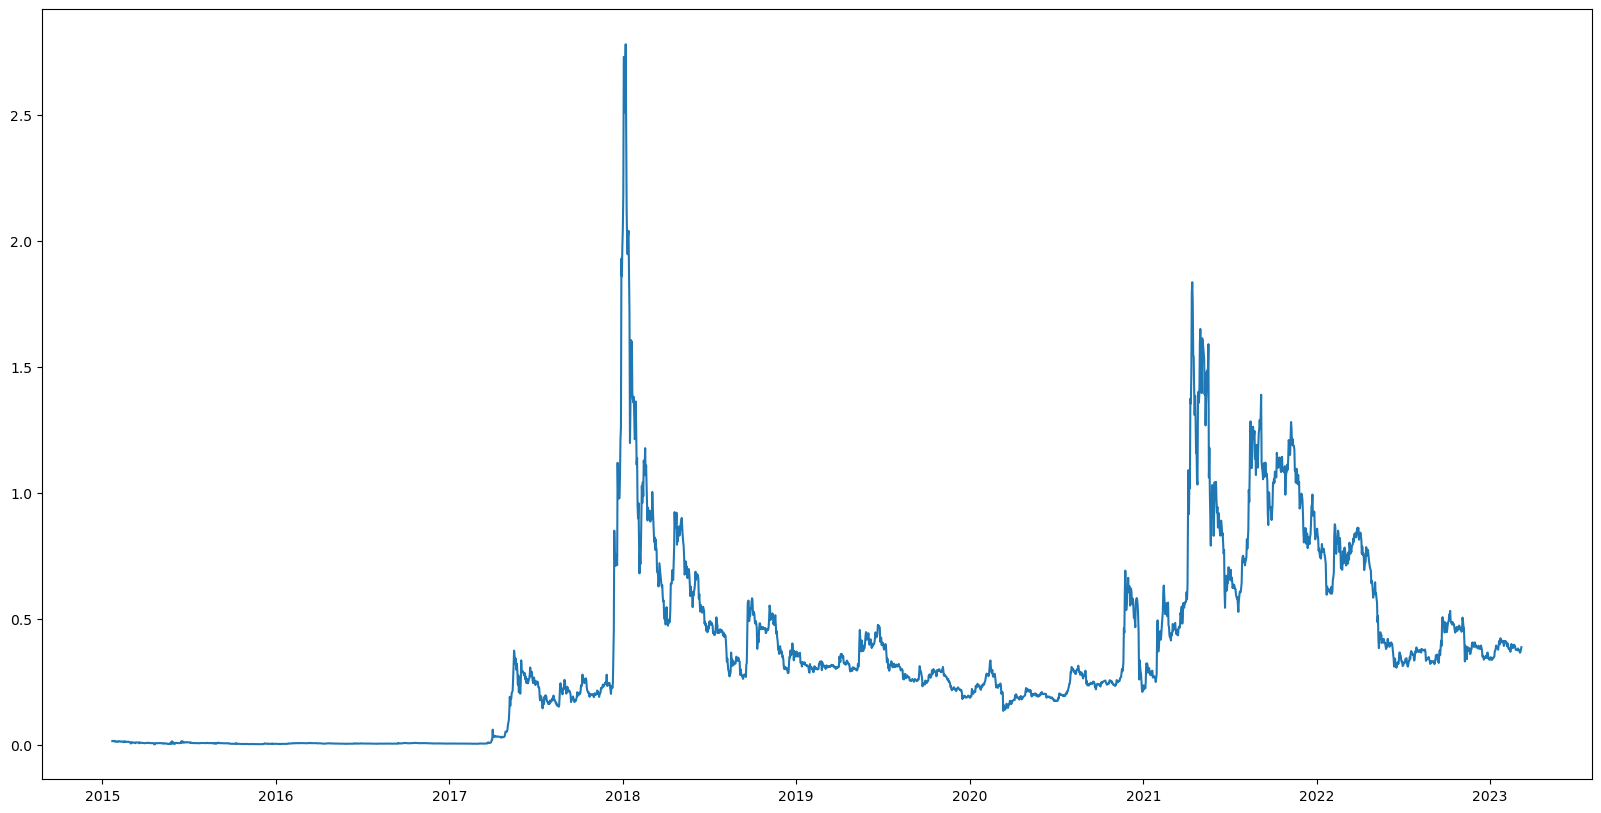

In [14]:
#Lets see our first visual of out historic price
plt.plot(nData)

In [15]:
dataset=nData.values #this copies the values of the data in nData
train=dataset[0:int(len(nData)*0.8-1),:] #first 80% of the data would be used to train the data
test=dataset[int(len(nData)*0.8-1):,:] #this sets 20% of the data of the most reent period of our dataset

In [16]:
dataset

array([[0.01602],
       [0.016],
       [0.01739],
       ...,
       [0.36964],
       [0.3802],
       [0.38874]], dtype=object)

In [17]:
len(train) #cheaking the size of the training set

2373

In [18]:
len(test) #lenght of the test set

595

In [19]:
# next we scale the data so the range is between 0 and 1

scaler = MinMaxScaler(feature_range=(0,1))#defining the range of our scaler
scaled_data = scaler.fit_transform(dataset) #pointing the scaler to our data set

scaled_data #quick look at the results

array([[0.00448776],
       [0.00448056],
       [0.0049812 ],
       ...,
       [0.1318523 ],
       [0.13565573],
       [0.13873161]])

#### Prepare our Data for Training a Recurrent Neural Network

for RNNs we use previous time steps as additional features. Good to choose an appropriate number of time steps (similar to batch size) which allows us to sufficiently sample the entire training set (training size / no. of time steps should be at least greater than 10)

In [20]:
#lets add some features. We will use the last 60 time period as features for our trainig data set
x_train, y_train=[],[] #empty list for the features

#next we loop through the training set

for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0]) #getting the last 60
    y_train.append(scaled_data[i,0]) #targeting only the current steps  
    
#convert to numpy array format
x_train, y_train =np.array(x_train), np.array(y_train)

# create a 3D tensor for the RNN network
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [21]:
x_train.shape

(2313, 60, 1)

In [22]:
x_train

array([[[0.00448776],
        [0.00448056],
        [0.0049812 ],
        ...,
        [0.00142629],
        [0.00235914],
        [0.00233392]],

       [[0.00448056],
        [0.0049812 ],
        [0.00484073],
        ...,
        [0.00235914],
        [0.00233392],
        [0.00222227]],

       [[0.0049812 ],
        [0.00484073],
        [0.00400873],
        ...,
        [0.00233392],
        [0.00222227],
        [0.00229791]],

       ...,

       [[0.42356039],
        [0.36105228],
        [0.32468197],
        ...,
        [0.210968  ],
        [0.20820907],
        [0.21005676]],

       [[0.36105228],
        [0.32468197],
        [0.28380588],
        ...,
        [0.20820907],
        [0.21005676],
        [0.19937402]],

       [[0.32468197],
        [0.28380588],
        [0.35580095],
        ...,
        [0.21005676],
        [0.19937402],
        [0.18911988]]])

### Lets fit the LSTM Model

In [23]:
# creat  LSTM network

model = Sequential()
model.add(LSTM(units=50, return_sequences =True, input_shape =(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [24]:
# compile with Adam and optimization and MSE loss

model.compile(loss="mean_squared_error", optimizer ="adam")

In [29]:
# fit the model and run the training process

model.fit(x_train, y_train, epochs=10,  batch_size=2, verbose=1)

#I could increase the epochs and batch size

Epoch 1/10
1157/1157 [==============================] - 23s 20ms/step - loss: 6.9336e-04
Epoch 2/10
1157/1157 [==============================] - 23s 20ms/step - loss: 5.0848e-04
Epoch 3/10
1157/1157 [==============================] - 23s 20ms/step - loss: 5.4773e-04
Epoch 4/10
1157/1157 [==============================] - 23s 20ms/step - loss: 3.7624e-04
Epoch 5/10
1157/1157 [==============================] - 23s 20ms/step - loss: 4.0624e-04
Epoch 6/10
1157/1157 [==============================] - 23s 19ms/step - loss: 3.9227e-04
Epoch 7/10
1157/1157 [==============================] - 23s 20ms/step - loss: 3.9723e-04
Epoch 8/10
1157/1157 [==============================] - 23s 20ms/step - loss: 3.6110e-04
Epoch 9/10
1157/1157 [==============================] - 23s 19ms/step - loss: 3.4721e-04
Epoch 10/10
1157/1157 [==============================] - 23s 20ms/step - loss: 3.4138e-04


In [31]:
# get data from 60 time steps b4 test set starts
inputs = nData[len(nData) - len(test) - 60:].values 

# last 60 values

inputs = inputs.reshape(-1,1) # -1 means use the number of rows in the source variable (input)
inputs = scaler.transform(inputs) # we need to scale again as model was trained on scaled data

# we start from row 60 of the TEST set
x_test = [] #creating a list

for i in range(60, inputs.shape[0]):
    x_test.append(inputs[i-60:i,0]) # gather up the last 60 time steps for each of the test set timesteps
x_test = np.array(x_test) # convert the actual test data to a numpy array

x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1)) # convert to 3D numpy array for predicting
pricePred = model.predict(x_test) # predict our stock price for next time step

#### Wrangle Data back to original format (unscaled) for plotting
# (reverse process)
pricePred = scaler.inverse_transform(pricePred) # reverse scale back into original units

In [32]:
inputs.shape

(655, 1)

In [33]:
# square root of the average squared error b/w actual (test) and 
# our prediction (pricePred)
rms = np.sqrt(np.mean(np.power((test-pricePred),2))) 
rms

0.043254765861539604

In [34]:
# our RMSE isnt too bad. it does beg the question if the model id over fitted or really good

In [35]:
pricePred

array([[0.55819476],
       [0.570481  ],
       [0.58955157],
       [0.59050214],
       [0.594751  ],
       [0.6105142 ],
       [0.62857616],
       [0.70658004],
       [0.7167564 ],
       [0.7307358 ],
       [0.7266024 ],
       [0.7097064 ],
       [0.72135556],
       [0.6912226 ],
       [0.70945483],
       [0.70458114],
       [0.7190496 ],
       [0.7823637 ],
       [0.7423811 ],
       [0.7943567 ],
       [0.81642133],
       [0.9731032 ],
       [0.905043  ],
       [1.0675753 ],
       [1.2216251 ],
       [1.2077935 ],
       [1.1437508 ],
       [1.0740589 ],
       [1.114711  ],
       [1.1684773 ],
       [1.1798198 ],
       [1.1420106 ],
       [1.1697046 ],
       [1.1776919 ],
       [1.0665357 ],
       [1.1362139 ],
       [0.9970286 ],
       [1.1544603 ],
       [1.050563  ],
       [1.092916  ],
       [1.0381539 ],
       [1.1394069 ],
       [1.1582004 ],
       [1.1870698 ],
       [1.227306  ],
       [1.1866615 ],
       [1.2576761 ],
       [1.315

In [36]:
nData["Price"].mean() #average price

0.3544278773584904

C:\Users\anuma\AppData\Local\Temp\ipykernel_25808\913410103.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_new["Predictions"] = pricePred # copy our predicted stock prices


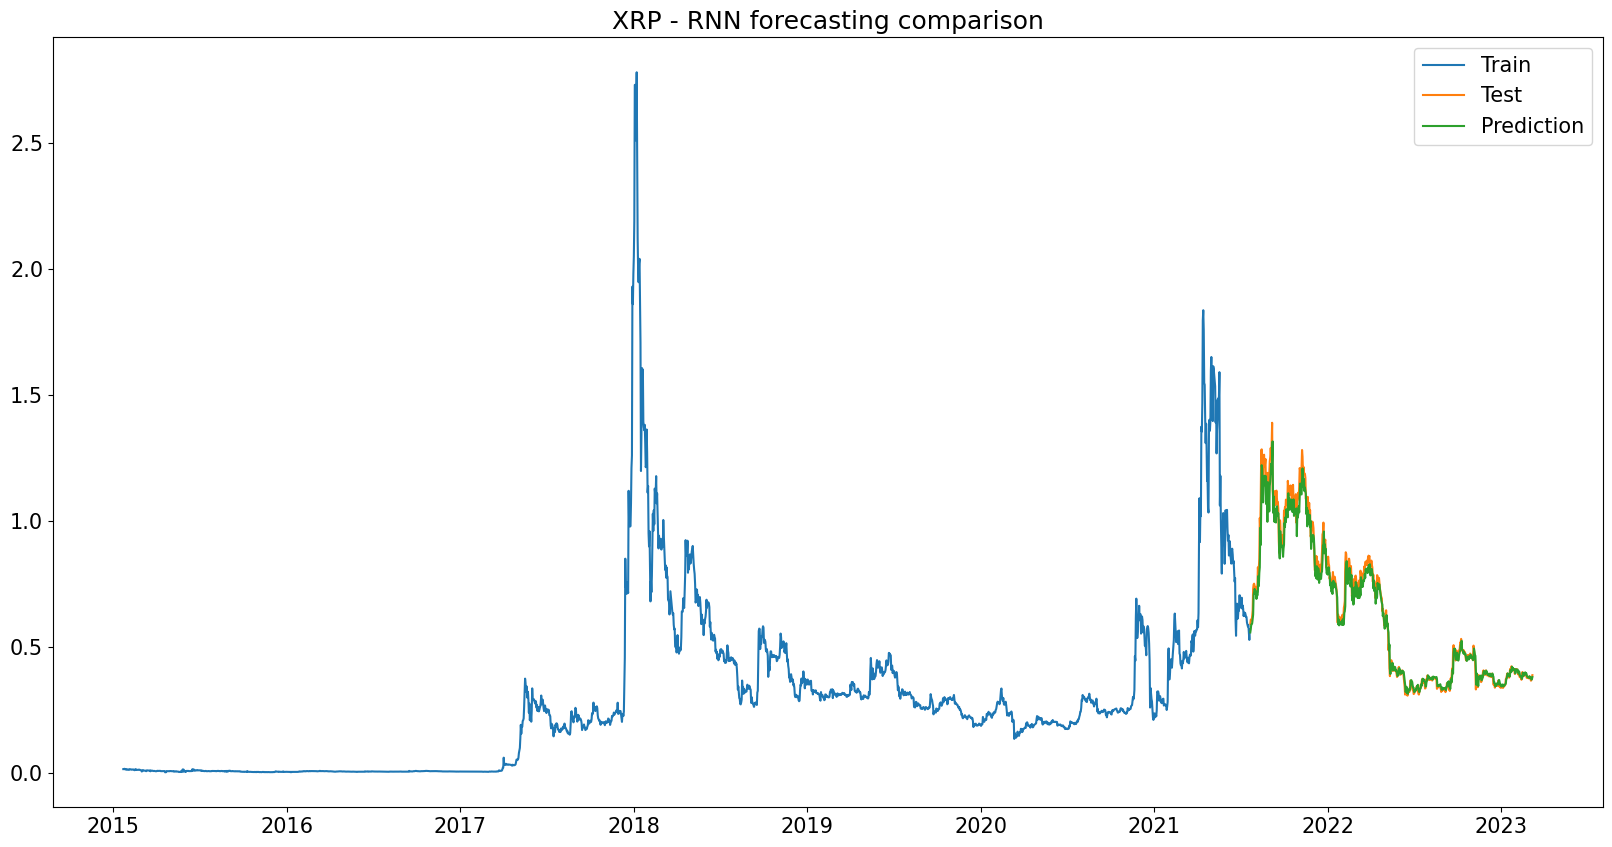

In [37]:
# plot the actual stock price time series chart against our predictions

# plot our training set, our test set and our predictions on the same chart
train_new = nData[:int(len(nData)*0.8-1)] # up to row number 80% of total rows in nData
test_new = nData[int(len(nData)*0.8-1):] # from row number 20% of total rows to the end
test_new["Predictions"] = pricePred # copy our predicted stock prices

plt.rcParams.update({'font.size': 15})

plt.plot(train_new["Price"]) # plot the training set data
plt.plot(test_new[["Price","Predictions"]]) # plot the test set stock prices and our predictions
# NB in line above we "combine" actual test stock prices and predictions oN THE SAME LINE of the chart

plt.title("XRP - RNN forecasting comparison")

plt.legend(["Train","Test","Prediction"]);

### Lets take a look into the future with a 2 weeks forecast

In [38]:

# Get data from 60 time steps before the test set starts
inputs = nData[len(nData) - len(test) - 60:].values 

# Reshape inputs to a column vector
inputs = inputs.reshape(-1, 1)

# Scale inputs
inputs = scaler.transform(inputs)

# Initialize x_test as a copy of inputs
x_test = np.copy(inputs)

# Predict stock prices for next 14 days (2 weeks)
num_days_to_predict = 14
predicted_prices = []

# Iterate over each day to be predicted
for i in range(num_days_to_predict):
    # Predict the price for the next time step
    next_pred = model.predict(np.expand_dims(x_test[-60:], axis=0))
    
    # Store the predicted price
    predicted_prices.append(scaler.inverse_transform(next_pred)[0, 0])
    
    # Update x_test with the predicted price for the next time step
    x_test = np.append(x_test, next_pred, axis=0)

# Wrangle predicted prices back to original format (unscaled)
predicted_prices = np.array(predicted_prices)

# Print the predicted prices for the next 14 days
print("Predicted prices for the next 14 days:")
print(predicted_prices)


Predicted prices for the next 14 days:
[0.3883513  0.3892081  0.39127618 0.39341804 0.39534518 0.39702117
 0.398461   0.39969158 0.40074256 0.40164328 0.40242115 0.40310058
 0.4037022  0.4042429 ]


In [ ]:
# Well, thats it. I have to monitor the results in real time over the next few days to see how my model does in the real world